In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from pycm import ConfusionMatrix
import json
from molfeat.calc import FPCalculator

calc = FPCalculator("fcfp-count")

In [4]:
# Load the JSON data
data_file = './collected_data/extracted_data_collected2.json'
with open(data_file, 'r') as file:
    data = json.load(file)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


# Analyze the data
for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out

In [5]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]

print(len(df_full), len(df_filtered))

1138 1108


In [6]:
def ensure_list(seq):
    if isinstance(seq, float) and np.isnan(seq):
        return []
    elif not isinstance(seq, list):
        return [seq]
    else:
        return seq

def preprocess_data(df):
    # Add r1, r2, and r1r2 columns
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']

    # Filter out rows with NaNs in monomer1, monomer2, or r1r2
    df.dropna(subset=['monomer1', 'monomer2', 'r1r2'], inplace=True)
    
    # Filter out rows where solvent is NaN and method is not 'bulk'
    df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]

    # Convert temperature lists to mean values
    df['temperature'] = df['temperature'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
    
    # Convert fingerprints to numpy arrays
    #df['fingerprint_1'] = df['fingerprint_1'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))
    #df['fingerprint_2'] = df['fingerprint_2'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))
    #df['solvent_fingerprint'] = df['solvent_fingerprint'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))


    df['fingerprint_1'] = [calc(monomer) for monomer in df['monomer1'].values]
    df['fingerprint_2'] = [calc(monomer) for monomer in df['monomer2'].values]
    solvent_fps = []
    for solvent in df['solvent'].values:
        try: 
            fp = calc(solvent)
            fp = np.array(fp)
            solvent_fps.append(fp)
        except:
            fp = np.zeros_like(df['fingerprint_1'].iloc[0])
            solvent_fps.append(fp)
    df['solvent_fingerprint'] = solvent_fps

    
    def normalized_stdev(x):
        return abs(x.std() / x.mean()) if x.mean() != 0 else 0

    grouped = df.groupby(['monomer1', 'monomer2', 'solvent', 'temperature']).agg({
        'r1r2': ['mean', 'count', 'std', normalized_stdev],
        'fingerprint_1': 'first',
        'fingerprint_2': 'first',
        'solvent_fingerprint': 'first'
    })
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.fillna(0, inplace=True)
    grouped_filtered = grouped[grouped['r1r2_normalized_stdev'] < 0.1]

    # Flatten the columns to get rid of the multiindex, keep only the "mean" aggregation
    mean_columns = grouped_filtered.reset_index()
    mean_columns = mean_columns[mean_columns['r1r2_mean'] >= 0]

    # Generate fingerprint arrays and ensure they are numeric
    monomer1_fps = np.vstack(mean_columns['fingerprint_1_first'].values)
    monomer2_fps = np.vstack(mean_columns['fingerprint_2_first'].values)
    solvent_fps = np.vstack(mean_columns['solvent_fingerprint_first'].values)

    sum_fp = monomer1_fps + monomer2_fps  # Sum of fingerprints
    
    # Ensure all arrays have the same number of dimensions
    sum_fp = sum_fp.reshape(-1, sum_fp.shape[1])
    solvent_fps = solvent_fps.reshape(-1, solvent_fps.shape[1])
    temperature = mean_columns['temperature'].values.reshape(-1, 1)
    
    # Check the lengths of all arrays
    print(f"Lengths: sum_fp={len(sum_fp)}, solvent_fps={len(solvent_fps)}, temperature={len(temperature)}")

    fingerprints_only = sum_fp
    all_features = np.hstack([sum_fp, solvent_fps, temperature])

    labels_class1 = (mean_columns['r1r2_mean'] <= 0.1).astype(int).values
    labels_class2 = (mean_columns['r1r2_mean'] > 1).astype(int).values

    all_smiles = set(mean_columns['monomer1'].values.tolist() + mean_columns['monomer2'].values.tolist())
    train_smiles, test_smiles = train_test_split(list(all_smiles), test_size=0.5)

    train_idx = np.where((mean_columns['monomer1'].isin(train_smiles) | mean_columns['monomer2'].isin(train_smiles)).values)[0]
    test_idx = np.where((~mean_columns['monomer1'].isin(train_smiles) & ~mean_columns['monomer2'].isin(train_smiles)).values)[0]

    train_fingerprints_only = fingerprints_only[train_idx]
    test_fingerprints_only = fingerprints_only[test_idx]
    train_all_features = all_features[train_idx]
    test_all_features = all_features[test_idx]
    train_labels_class1 = labels_class1[train_idx]
    test_labels_class1 = labels_class1[test_idx]
    train_labels_class2 = labels_class2[train_idx]
    test_labels_class2 = labels_class2[test_idx]

    print(f"Lengths of train/test sets: {len(train_fingerprints_only)}, {len(test_fingerprints_only)}")
    return train_fingerprints_only, test_fingerprints_only, train_all_features, test_all_features, train_labels_class1, test_labels_class1, train_labels_class2, test_labels_class2


In [7]:
# Preprocess data for Model 1 & 2 (unfiltered data)
train_fingerprints_only_full, test_fingerprints_only_full, train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, train_labels_class2_full, test_labels_class2_full = preprocess_data(df_full)

# Preprocess data for Model 3 (filtered data)
train_fingerprints_only_filtered, test_fingerprints_only_filtered, train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, train_labels_class2_filtered, test_labels_class2_filtered = preprocess_data(df_filtered)

print(len(train_fingerprints_only_full), len(test_fingerprints_only_full))
print(len(train_fingerprints_only_filtered), len(test_fingerprints_only_filtered))
print(len(train_all_features_filtered), len(test_all_features_filtered))

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_4115/382467676.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temperature'] = df['temperature'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_4115/382467676.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fingerprint_1'] = [calc(mono

Lengths: sum_fp=613, solvent_fps=613, temperature=613
Lengths of train/test sets: 396, 217


/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_4115/382467676.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_4115/382467676.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/m9/_txh68y946s4px

Lengths: sum_fp=599, solvent_fps=599, temperature=599
Lengths of train/test sets: 422, 177
396 217
422 177
422 177


In [8]:
from sklearn.metrics import cohen_kappa_score

# Function to train and evaluate a model
def train_and_evaluate_model(train_features, test_features, train_labels, test_labels, title):
    model = HistGradientBoostingClassifier(max_iter=500, class_weight={0:1, 1:50})
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)

    # Evaluate Model
    cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=predictions)
    print(cm)
    
    # Calculate Kappa score
    kappa = cohen_kappa_score(test_labels, predictions)
    print(f"Kappa: {kappa:.3f}")
    
    # Plot confusion matrix
    sns.heatmap(pd.DataFrame(cm.normalized_matrix), annot=True,  cbar=False)
    plt.title(f"{title}\nKappa = {kappa:.3}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Predict   0         1         
Actual
0         114       25        

1         41        37        





Overall Statistics : 

95% CI                                                            (0.63464,0.75706)
ACC Macro                                                         0.69585
ARI                                                               0.13792
AUNP                                                              0.64725
AUNU                                                              0.64725
Bangdiwala B                                                      0.54452
Bennett S                                                         0.39171
CBA                                                               0.60492
CSI                                                               0.31338
Chi-Squared                                                       21.23366
Chi-Squared DF                                                    1
Conditional Entropy                                 

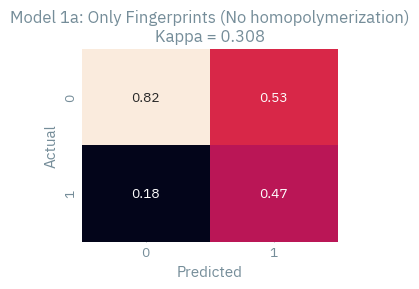

Predict   0         1         
Actual
0         163       26        

1         11        17        





Overall Statistics : 

95% CI                                                            (0.77945,0.87953)
ACC Macro                                                         0.82949
ARI                                                               0.29111
AUNP                                                              0.73479
AUNU                                                              0.73479
Bangdiwala B                                                      0.78786
Bennett S                                                         0.65899
CBA                                                               0.62889
CSI                                                               0.40085
Chi-Squared                                                       33.84348
Chi-Squared DF                                                    1
Conditional Entropy                                 

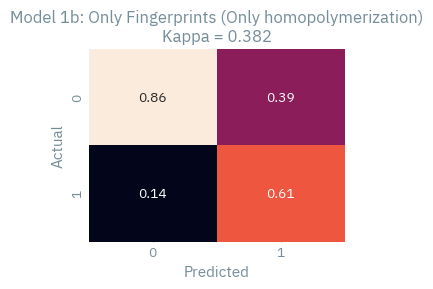

In [9]:
# Model 1a: Training with only the fingerprints of the monomers (full data) for Class 1
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class1_full, test_labels_class1_full, "Model 1a: Only Fingerprints (No homopolymerization)")

# Model 1b: Training with only the fingerprints of the monomers (full data) for Class 2
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class2_full, test_labels_class2_full, "Model 1b: Only Fingerprints (Only homopolymerization)")

Predict   0         1         
Actual
0         112       27        

1         35        43        





Overall Statistics : 

95% CI                                                            (0.65418,0.77439)
ACC Macro                                                         0.71429
ARI                                                               0.17235
AUNP                                                              0.67852
AUNU                                                              0.67852
Bangdiwala B                                                      0.55586
Bennett S                                                         0.42857
CBA                                                               0.65659
CSI                                                               0.36661
Chi-Squared                                                       29.14616
Chi-Squared DF                                                    1
Conditional Entropy                                 

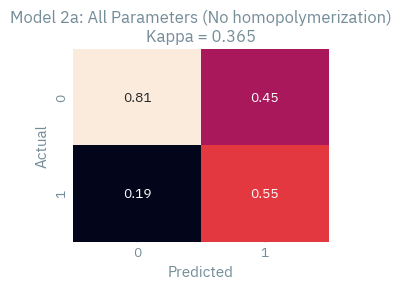

Predict   0         1         
Actual
0         173       16        

1         17        11        





Overall Statistics : 

95% CI                                                            (0.80015,0.8957)
ACC Macro                                                         0.84793
ARI                                                               0.25085
AUNP                                                              0.6541
AUNU                                                              0.6541
Bangdiwala B                                                      0.81956
Bennett S                                                         0.69585
CBA                                                               0.65169
CSI                                                               0.31307
Chi-Squared                                                       21.26329
Chi-Squared DF                                                    1
Conditional Entropy                                    

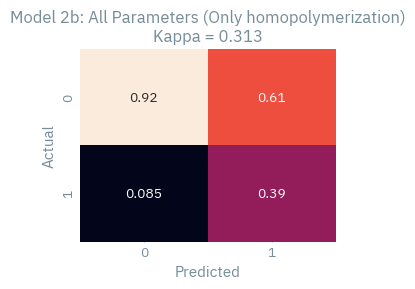

In [10]:
# Model 2a: Training with all parameters (full data) for Class 1
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, "Model 2a: All Parameters (No homopolymerization)")

# Model 2b: Training with all parameters (full data) for Class 2
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class2_full, test_labels_class2_full, "Model 2b: All Parameters (Only homopolymerization)")

Predict   0         1         
Actual
0         115       21        

1         26        15        





Overall Statistics : 

95% CI                                                            (0.6694,0.79952)
ACC Macro                                                         0.73446
ARI                                                               0.12935
AUNP                                                              0.60572
AUNU                                                              0.60572
Bangdiwala B                                                      0.65127
Bennett S                                                         0.46893
CBA                                                               0.59073
CSI                                                               0.22186
Chi-Squared                                                       8.69274
Chi-Squared DF                                                    1
Conditional Entropy                                   

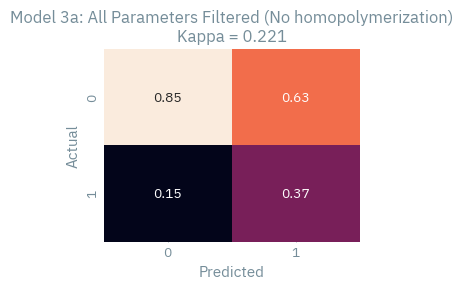

Predict   0         1         
Actual
0         131       23        

1         11        12        





Overall Statistics : 

95% CI                                                            (0.74987,0.86595)
ACC Macro                                                         0.80791
ARI                                                               0.22228
AUNP                                                              0.68619
AUNU                                                              0.68619
Bangdiwala B                                                      0.76324
Bennett S                                                         0.61582
CBA                                                               0.59675
CSI                                                               0.31889
Chi-Squared                                                       17.49274
Chi-Squared DF                                                    1
Conditional Entropy                                 

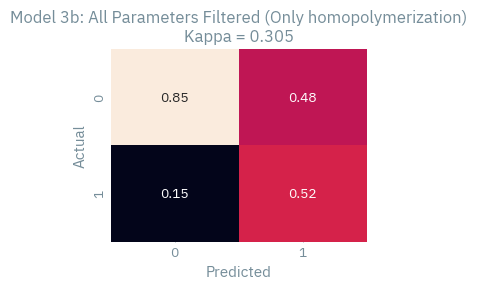

In [11]:
# Model 3a: Training with filtered data (all parameters) for Class 1
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, "Model 3a: All Parameters Filtered (No homopolymerization)")

# Model 3b: Training with filtered data (all parameters) for Class 2
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class2_filtered, test_labels_class2_filtered, "Model 3b: All Parameters Filtered (Only homopolymerization)")

Best hyperparameters for Model 1a: Only Fingerprints (No homopolymerization): {'min_samples_leaf': 20, 'max_leaf_nodes': 63, 'max_iter': 400, 'learning_rate': 0.2, 'class_weight': {0: 1, 1: 50}}
Kappa: 0.316
Best hyperparameters for Model 1b: Only Fingerprints (Only homopolymerization): {'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 500, 'learning_rate': 0.01, 'class_weight': {0: 1, 1: 100}}
Kappa: 0.177
Best hyperparameters for Model 2a: All Parameters (No homopolymerization): {'min_samples_leaf': 30, 'max_leaf_nodes': 31, 'max_iter': 500, 'learning_rate': 0.2, 'class_weight': {0: 1, 1: 10}}
Kappa: 0.219
Best hyperparameters for Model 2b: All Parameters (Only homopolymerization): {'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 400, 'learning_rate': 0.1, 'class_weight': {0: 1, 1: 10}}
Kappa: 0.278
Best hyperparameters for Model 3a: All Parameters Filtered (No homopolymerization): {'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 500, 'learning_rate': 0.0

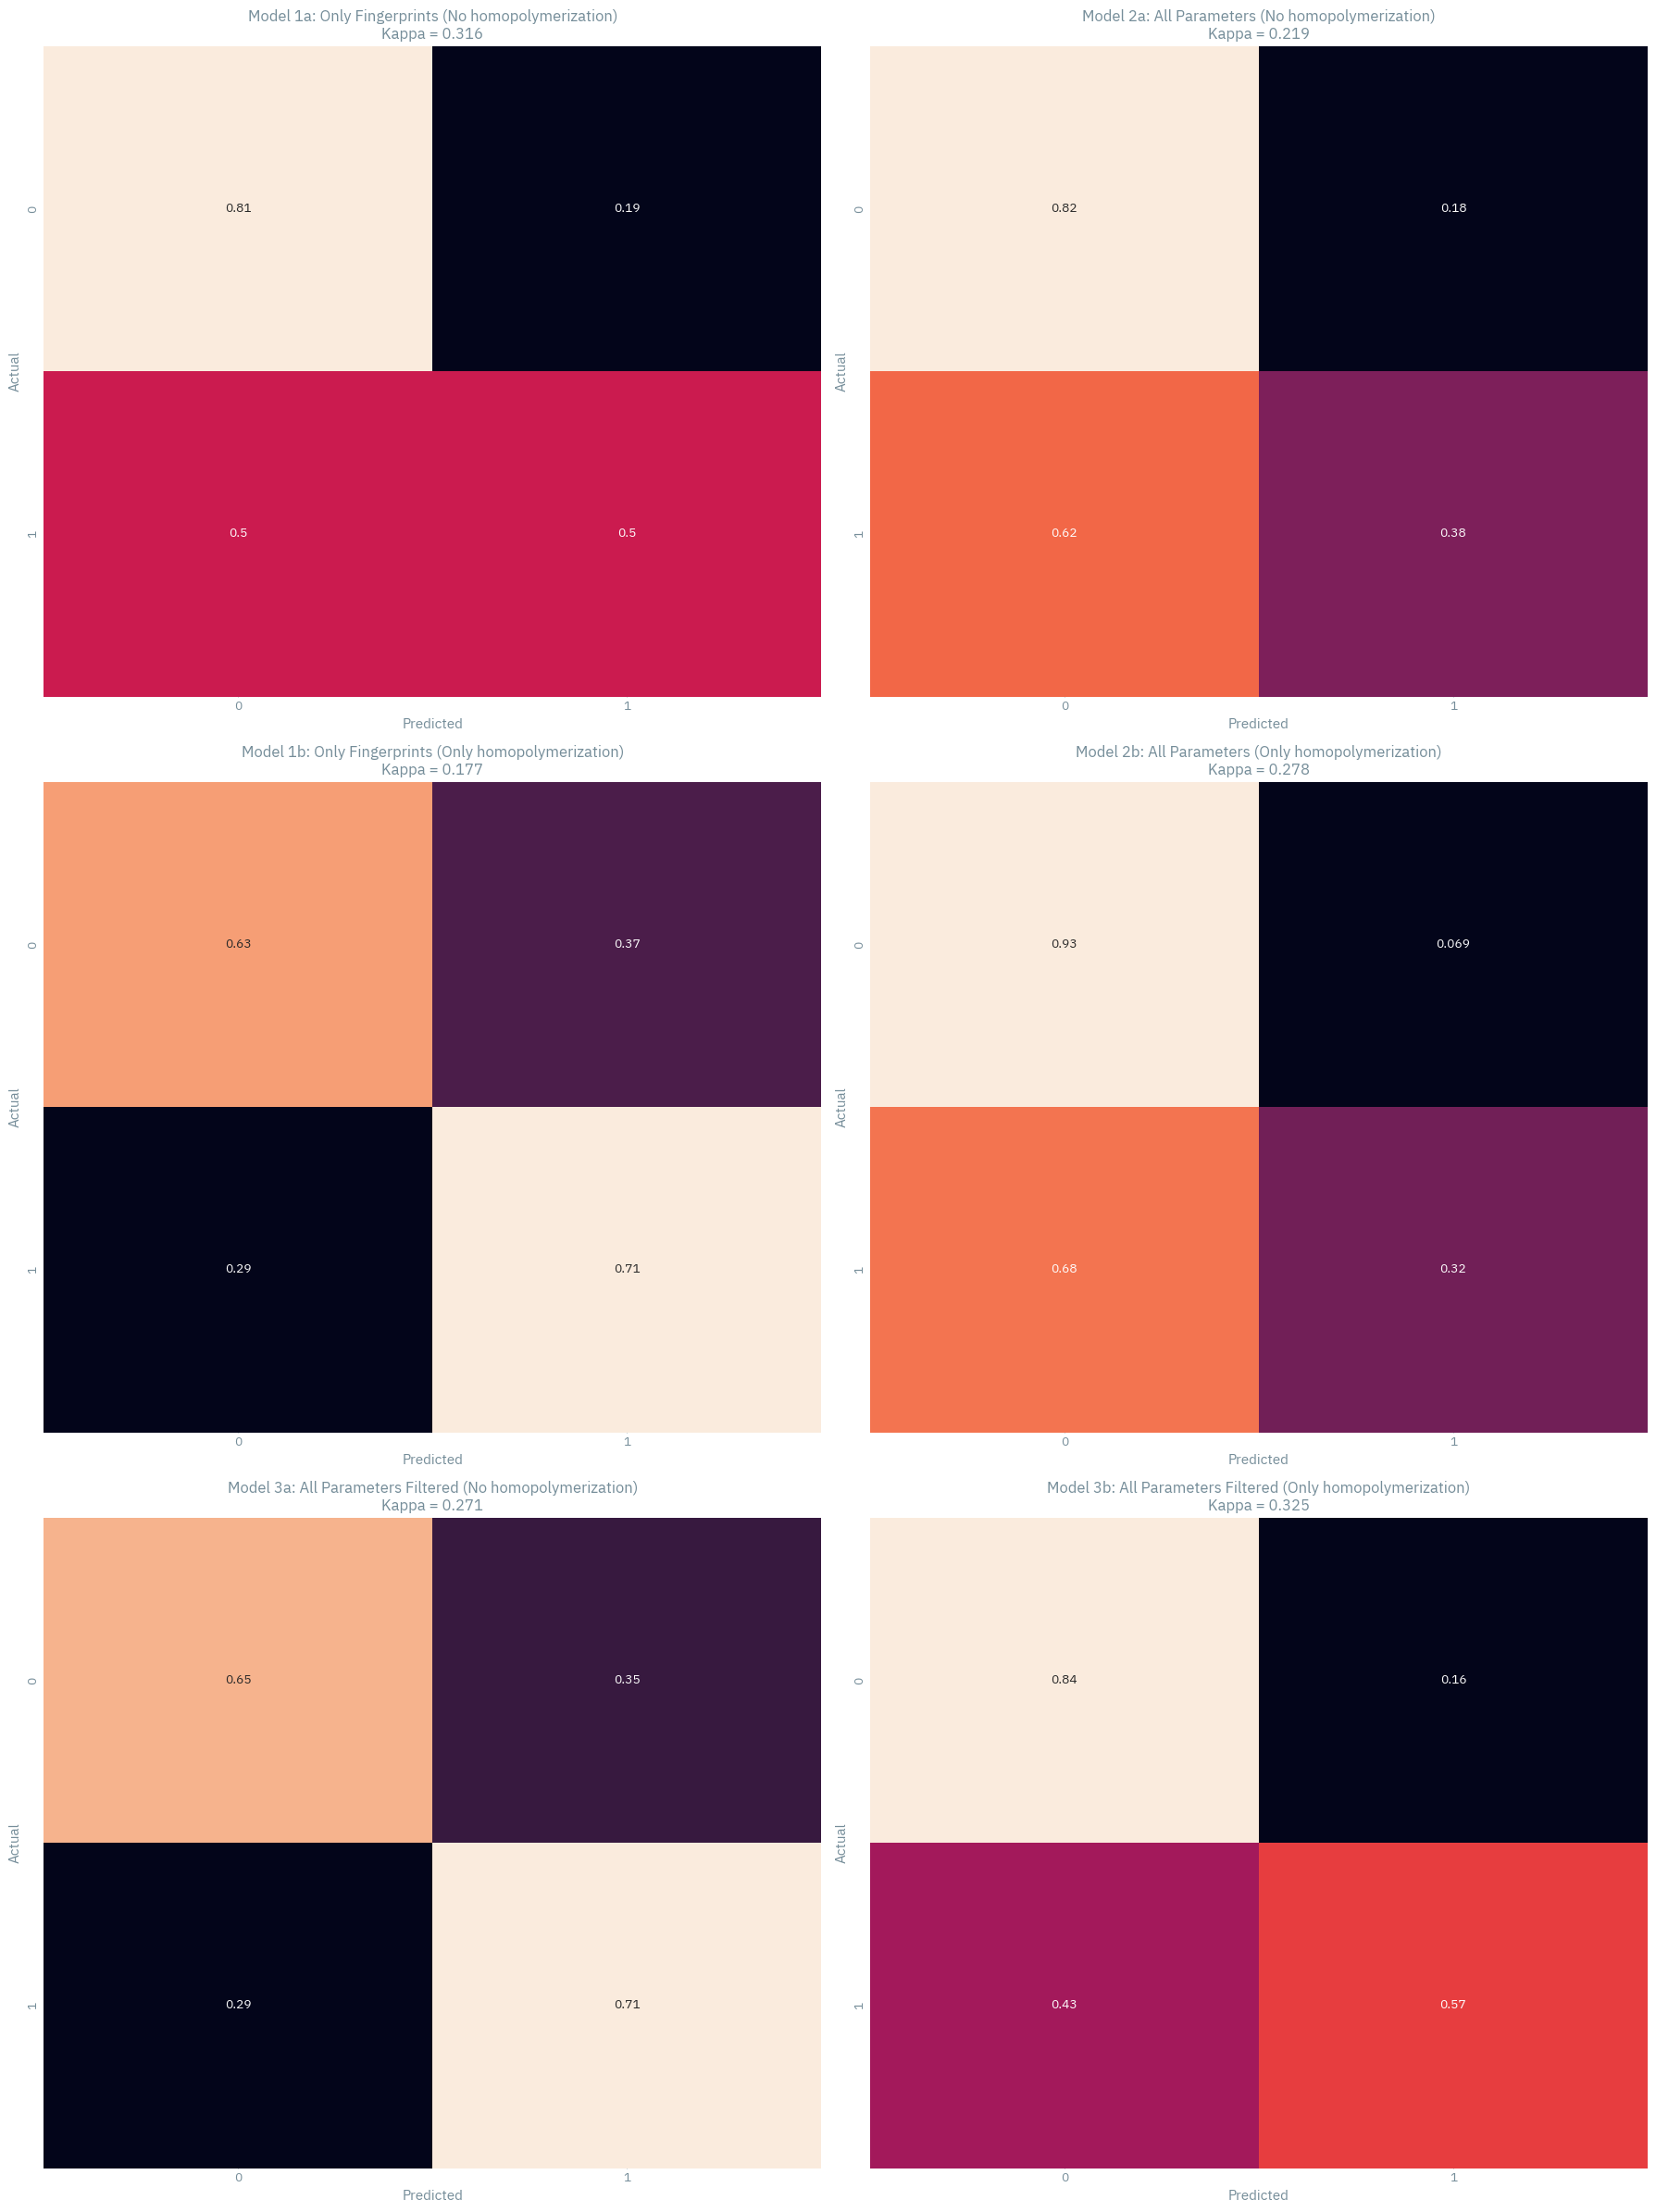

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.backends.backend_pdf

# Function to load data from a JSON file
def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)
    
# Custom scoring function for Cohen's kappa
kappa_scorer = make_scorer(cohen_kappa_score)

# Function to train and evaluate a model and plot confusion matrix in a given subplot
def train_and_evaluate_model(train_features, test_features, train_labels, test_labels, title, ax):
    # Define the parameter grid for RandomizedSearchCV
    param_distributions = {
        'max_iter': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_leaf_nodes': [15, 31, 63],
        'min_samples_leaf': [10, 20, 30],
        'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 50}, {0: 1, 1: 100}]
    }
    
    # Define the base model
    base_model = HistGradientBoostingClassifier(random_state=42)
    
    # Perform RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=50,  # Number of parameter settings sampled
        scoring=kappa_scorer,  # Evaluation metric
        cv=3,  # Number of folds in cross-validation
        random_state=42,
        n_jobs=-1  # Use all available CPUs
    )
    
    search.fit(train_features, train_labels)
    
    # Best model
    best_model = search.best_estimator_
    print(f"Best hyperparameters for {title}: {search.best_params_}")
    
    predictions = best_model.predict(test_features)

    # Evaluate Model
    cm = confusion_matrix(test_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Calculate Kappa score
    kappa = cohen_kappa_score(test_labels, predictions)
    print(f"Kappa: {kappa:.3f}")


    # Plot confusion matrix
    sns.heatmap(pd.DataFrame(cm_normalized), annot=True, cbar=False, ax=ax)
    ax.set_title(f"{title}\nKappa = {kappa:.3}")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

# Create a PDF to save the plots
pdf = matplotlib.backends.backend_pdf.PdfPages("combined_plots.pdf")

# Create a figure with multiple subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 24))

# Call the function for each model and plot in the corresponding subplot
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class1_full, test_labels_class1_full, "Model 1a: Only Fingerprints (No homopolymerization)", axs[0, 0])
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class2_full, test_labels_class2_full, "Model 1b: Only Fingerprints (Only homopolymerization)", axs[1, 0])
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, "Model 2a: All Parameters (No homopolymerization)", axs[0, 1])
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class2_full, test_labels_class2_full, "Model 2b: All Parameters (Only homopolymerization)", axs[1, 1])
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, "Model 3a: All Parameters Filtered (No homopolymerization)", axs[2, 0])
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class2_filtered, test_labels_class2_filtered, "Model 3b: All Parameters Filtered (Only homopolymerization)", axs[2, 1])

# Adjust layout
plt.tight_layout()

# Save the figure to the PDF
pdf.savefig(fig)

# Close the PDF
pdf.close()

# Show the combined plot
plt.show()